In [1]:
import pandas as pd
import torch 
import matplotlib.pyplot as plt
import numpy as np
import os
from functools import lru_cache
import gc

In [2]:
np.version.version

size = 10

In [3]:
p1 = os.path.expanduser('~/Downloads/transmissions/size_10/lead_size_10_conc_7_config_659.csv')
np.loadtxt(p1, delimiter=',', skiprows=1)[:,1]

array([3.22547128e+01, 6.75769353e+00, 6.59164184e+00, 6.18413891e+00,
       5.86467772e+00, 5.83907996e+00, 6.92377189e+00, 6.27770362e+00,
       8.66612086e+00, 6.24439845e+00, 1.46236236e+01, 4.50108767e+00,
       1.26078590e+00, 1.85971752e+01, 6.10217825e+00, 2.53083303e+00,
       1.51785593e+00, 6.35202898e+00, 3.27893943e+01, 5.22022679e+00,
       4.10031884e+00, 1.38960000e+00, 6.88072339e+00, 3.59656902e+01,
       6.74524804e+00, 7.40165629e+00, 4.44893416e+00, 6.89999786e+00,
       7.20718040e+01, 6.84279734e+00, 2.44472324e+01, 5.55315038e+00,
       2.14607927e+00, 3.61237937e+00, 6.21001900e+00, 2.37665942e+01,
       5.73911622e+00, 5.30160882e+00, 4.25630160e+01, 6.41445487e+00,
       6.42545237e+00, 1.04714529e+01, 7.09230445e+00, 2.59633725e+01,
       5.83093402e+00, 3.14958853e+01, 6.99347842e+00, 6.71080902e+00,
       2.16896243e+00, 6.95833005e+00, 5.69506158e+00, 5.09545446e+00,
       7.05576827e+00, 5.65622870e+00, 6.79512825e+00, 7.33425774e+00,
      

In [4]:
@lru_cache(maxsize=1024)
def configs(conc):
    df = {}
    for x in range(5000):
        path = os.path.expanduser(f'~/Downloads/transmissions/size_10/lead_size_10_conc_{conc}_config_{x}.csv')
        new_data = np.loadtxt(path, delimiter=',',skiprows=1)[:,1]
        df[x] = new_data
    df = pd.DataFrame(df)
    df.index = np.arange(0, 4, 0.01)
    return df.clip(upper=size)


In [ ]:
configs(7)

In [5]:
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import pdist, squareform

In [ ]:
np.random.seed(42)
random_configs =sorted(np.random.choice(np.arange(0,999,1), 800,replace=False))

In [ ]:
for conc in np.arange(5,50,5):
    train = configs(conc).iloc[:,random_configs]
    test = configs(conc).drop(columns=random_configs)
    train.to_csv(f'~/Downloads/transmissions/train_conc_{conc}.csv')
    test.to_csv(f'~/Downloads/transmissions/test_conc_{conc}.csv')

In [6]:
DEVICE_COMBS = {}

@lru_cache(maxsize=1024)
def chosen_for_config(n, size, config):
    width = int(size); n = int(n); cfg = int(config)
    if width not in DEVICE_COMBS:
        DEVICE_COMBS[width] = np.array([(i, j) for i in range(100) for j in range(width)], dtype=int)
    device_combs = DEVICE_COMBS[width]
    rng = np.random.RandomState(cfg)
    chosen_indices = rng.choice(len(device_combs), size=n, replace=False)
    return device_combs[chosen_indices]


def possible_combs(n, width):
    def combs_for_seed(x):
        return chosen_for_config(n, width, x)
    return combs_for_seed

In [7]:
@lru_cache(maxsize=1024)
def distance_matrix(conc,config):
    imps  = possible_combs(conc, size)
    item = imps(config)
    #print(np.diag(item[:,1]))
    x = np.stack((size - item[:,1],item[:,1]), axis=1)
    return squareform(pdist(item, metric='euclidean')) + np.diag(x.min(axis=1))

In [ ]:
from itertools import combinations
abc = possible_combs(7,10)
abc(659)

In [ ]:
np.linalg.inv(distance_matrix(7,10))

In [8]:
def create_dataset():
    x = []
    y = []
    for conc in np.arange(7,50,2):
        print(f"Processing concentration: {conc}")
        for config in range(5000):
            dist_mat = 0 *np.eye(50)
            dist_mat[:conc,:conc] +=  np.linalg.inv(distance_matrix(conc, config))
            x.append(dist_mat)
            arr = configs(conc).index,configs(conc)[config]
            arr = np.array(arr).T
            y.append(arr)


    x = np.array(x)
    y = np.array(y)
    print(f"Shape of x: {x.shape}")
    print(f"Shape of y: {y.shape}")

    return x,y

In [9]:
x,y = create_dataset()

Processing concentration: 7
Processing concentration: 9
Processing concentration: 11
Processing concentration: 13
Processing concentration: 15
Processing concentration: 17
Processing concentration: 19
Processing concentration: 21
Processing concentration: 23
Processing concentration: 25
Processing concentration: 27
Processing concentration: 29
Processing concentration: 31
Processing concentration: 33
Processing concentration: 35
Processing concentration: 37
Processing concentration: 39
Processing concentration: 41
Processing concentration: 43
Processing concentration: 45
Processing concentration: 47
Processing concentration: 49
Shape of x: (110000, 50, 50)
Shape of y: (110000, 400, 2)


In [ ]:
x[0]

In [13]:
import torch
import torch.nn as nn

In [14]:
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split

In [21]:

class CNNRegressor(nn.Module):
    """
    A generalized CNN Regressor that can handle input matrices of any size (e.g., x*x).
    It uses an Adaptive Average Pooling layer to ensure the output of the CNN
    part is a fixed size before feeding it to the fully connected layers.
    """
    def __init__(self, out_features=800):
        super(CNNRegressor, self).__init__()
        
        # Part 1: CNN layers that can read any input size
        self.cnn_part = nn.Sequential(
            # Input is (Batch, 1, X, X)
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=3),
            nn.ReLU(),
            # Adaptive Pooling is the key to generalization.
            # It will always output a 1x1 spatial size for each of the 32 channels.
            nn.AdaptiveAvgPool2d((1, 1)) # -> (Batch, 32, 1, 1)
        )
        
        # Part 2: Flatten and Fully Connected layers for regression
        self.mlp_part = nn.Sequential(
            nn.Flatten(),
            # Because of AdaptiveAvgPool2d, the flattened size is ALWAYS 32*1*1 = 32
            nn.Linear(in_features=64, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=out_features) # Final output layer
        )

    def forward(self, x):
        # Ensure input has a channel dimension
        if x.dim() == 3:
            # Unsqueeze to add the channel dimension: (Batch, X, X) -> (Batch, 1, X, X)
            x = x.unsqueeze(1)
            
        x = self.cnn_part(x)
        x = self.mlp_part(x)
        return x


In [ ]:
class MatrixDataset(Dataset):
    def __init__(self, x_matrices, y_matrices):
        # Prepare X: add channel dimension
        self.X = torch.tensor(np.array(x_matrices), dtype=torch.float32).unsqueeze(1)
        
        # Prepare Y: flatten the 400x2 matrix into a 1D vector of size 800
        num_samples = y_matrices.shape[0]
        self.y = torch.tensor(y_matrices, dtype=torch.float32).reshape(num_samples, -1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [23]:
full_dataset = MatrixDataset(x, y)
loader = DataLoader(full_dataset, batch_size=128, shuffle=True)

In [ ]:

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)


# --- 4. The Training Loop ---

# Set device (use GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
LEARNING_RATE = 0.0001
EPOCHS = 500

# Initialize the model, loss function, and optimizer
model = CNNRegressor(out_features=800).to(device)
loss_fn = nn.MSELoss() # Mean Squared Error is good for regression
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- Start Training ---
for epoch in range(EPOCHS):
    model.train() # Set the model to training mode
    
    # Loop over the training data
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Move data and targets to the selected device
        data = data.to(device)
        targets = targets.to(device)
        
        # 1. Forward pass: get predictions
        predictions = model(data)
        
        # 2. Calculate loss
        loss = loss_fn(predictions, targets)
        
        # 3. Backward pass: compute gradients
        optimizer.zero_grad() # Reset gradients from previous step
        loss.backward()
        
        # 4. Update weights
        optimizer.step()

    # --- Validation Loop ---
    model.eval() # Set the model to evaluation mode
    val_loss = 0
    with torch.no_grad(): # Disable gradient calculation for validation
        for data, targets in val_loader:
            data = data.to(device)
            targets = targets.to(device)
            
            predictions = model(data)
            val_loss += loss_fn(predictions, targets).item()
    
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} | Training Loss: {loss.item():.4f} | Validation Loss: {avg_val_loss:.4f}")

print("\nTraining finished!")


Using device: cpu
Epoch 1/500 | Training Loss: 3.3409 | Validation Loss: 3.4390
Epoch 2/500 | Training Loss: 3.5839 | Validation Loss: 3.4275
Epoch 3/500 | Training Loss: 3.2101 | Validation Loss: 4.2734
Epoch 4/500 | Training Loss: 3.0827 | Validation Loss: 4.1691
Epoch 5/500 | Training Loss: 3.2122 | Validation Loss: 3.2735
Epoch 6/500 | Training Loss: 3.0941 | Validation Loss: 3.2549
Epoch 7/500 | Training Loss: 3.1318 | Validation Loss: 3.2507
Epoch 8/500 | Training Loss: 3.1756 | Validation Loss: 3.2567
Epoch 9/500 | Training Loss: 3.3143 | Validation Loss: 3.2672
Epoch 10/500 | Training Loss: 3.2405 | Validation Loss: 3.2939
Epoch 11/500 | Training Loss: 3.0946 | Validation Loss: 3.3509
Epoch 12/500 | Training Loss: 3.2835 | Validation Loss: 3.2444
Epoch 13/500 | Training Loss: 3.2116 | Validation Loss: 8.3965
Epoch 14/500 | Training Loss: 3.2030 | Validation Loss: 3.2756
Epoch 15/500 | Training Loss: 3.0500 | Validation Loss: 3.5730
Epoch 16/500 | Training Loss: 3.3136 | Validat


--- Checking a sample prediction ---
Input 5x5 Matrix:
[[-0.6725301   0.0124396  -0.00508356 ...  0.          0.
   0.        ]
 [ 0.0124396   0.21383274  0.00344744 ...  0.          0.
   0.        ]
 [-0.00508356  0.00344744 -0.38513368 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


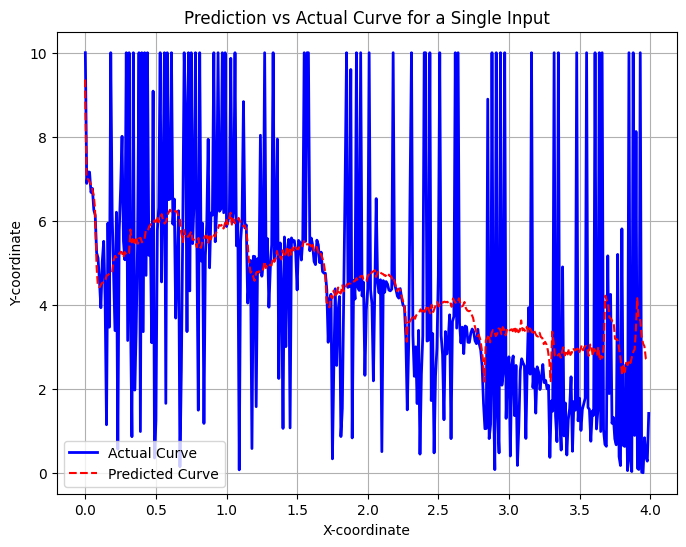

In [25]:


# --- 5. Making and Plotting Predictions ---
print("\n--- Checking a sample prediction ---")
model.eval() # Set the model to evaluation mode

# Get a single batch from the validation loader
with torch.no_grad():
    inputs, targets = next(iter(val_loader))
    inputs = inputs.to(device)
    targets = targets.to(device)
    
    # Get the model's predictions for this batch
    predictions = model(inputs)
    
    # --- Let's look at the very first sample in the batch ---
    
    # Get the original 5x5 input matrix
    input_matrix = inputs[4].cpu().numpy().squeeze()
    
    # The prediction is a flat vector of 800 numbers. Reshape it back to 400x2.
    pred_matrix = predictions[4].reshape(400, 2).cpu().numpy()
    
    # The target is also a flat vector. Reshape it back as well.
    target_matrix = targets[4].reshape(400, 2).cpu().numpy()

    # Print the input matrix
    print("Input 5x5 Matrix:")
    print(input_matrix)
    
    # Plot the results
    plt.figure(figsize=(8, 6))
    plt.plot(target_matrix[:, 0], target_matrix[:, 1], label='Actual Curve', color='blue', linewidth=2)
    plt.plot(pred_matrix[:, 0], pred_matrix[:, 1], label='Predicted Curve', color='red', linestyle='--')
    plt.title('Prediction vs Actual Curve for a Single Input')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    #plt.xlim(0, 4)
    plt.legend()
    plt.grid(True)
#    plt.axis('equal')
    plt.show()

